# lasagne
* lasagne is a library for neural network building and training
* it's a low-level library with almost seamless integration with theano

For a demo we shall solve the same digit recognition problem, but at a different scale
* images are now 28x28
* 10 different digits
* 50k samples

In [1]:
import numpy as np
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import sys
import os
import time
%matplotlib inline

In [2]:
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [3]:
#from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()

print(X_train.shape,y_train.shape)

(50000, 1, 28, 28) (50000,)


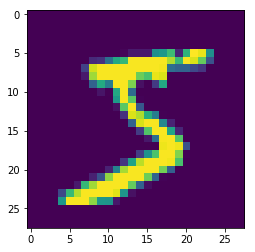

In [4]:
plt.imshow(X_train[0, 0])

In [5]:
input_X = T.tensor4("X")

#input dimention (None means "Arbitrary" and only works at  the first axes [samples])
input_shape = [None,1,28,28]

target_y = T.vector("target Y integer",dtype='int32')

Defining network architecture

In [8]:
import lasagne
from lasagne.layers import *

#Input layer (auxilary)
l_in = InputLayer(shape = input_shape,input_var=input_X)

#fully connected layer, that takes input layer and applies 50 neurons to it.
# nonlinearity here is sigmoid as in logistic regression
# you can give a name to each layer (optional)
#l2 = DenseLayer(l1, num_units=50, nonlinearity=lasagne.nonlinearities.softmax)
#l3 = Conv2DLayer(l2, num_filters=32, filter_size=5)
#l3 = MaxPool2DLayer(l2,2)
#l4 = DropoutLayer(l2, 0.5)
#l5 = Conv2DLayer(l4, num_filters=25, filter_size=(5, 5), nonlinearity=lasagne.nonlinearities.rectify)
#l6 = DenseLayer(l4, num_units=100,nonlinearity = lasagne.nonlinearities.sigmoid)
#l7 = MaxPool2DLayer(l6, pool_size=(3, 3))
#l8 = DropoutLayer(l6, p=0.5)

#l1 = Conv2DLayer(l_in, num_filters=32, filter_size=(5,5))
#l2 = MaxPool2DLayer(l1, 2)
#l3 = DropoutLayer(l2, p=0.5)
#l4 = DenseLayer(l3, num_units=100)

l1 = ReshapeLayer(l_in, (-1,1,28,28))

l1 = Conv2DLayer(l_in, num_filters=32, filter_size=5, pad=1)

l2 = MaxPool2DLayer(l1, pool_size=2)

l3 = Conv2DLayer(l2, num_filters=10, filter_size=3, pad=1)

l4 = MaxPool2DLayer(l3, pool_size=(3,3))

l5 = DropoutLayer(l4, p=0.5)

l6 = DenseLayer(l5,num_units=100,nonlinearity = lasagne.nonlinearities.elu)


#fully connected output layer that takes dense_1 as input and has 10 neurons (1 for each digit)
#We use softmax nonlinearity to make probabilities add up to 1
l_out = DenseLayer(l6, num_units = 10, nonlinearity=lasagne.nonlinearities.softmax)


In [15]:
import lasagne
from lasagne.layers import *

#Input layer (auxilary)
l1 = InputLayer(shape = input_shape,input_var=input_X)

l2 = Conv2DLayer(l1, num_filters=25, filter_size=(5, 5), nonlinearity=lasagne.nonlinearities.rectify)

l3 = Pool2DLayer(l2, pool_size=(3, 3))

l4 = Conv2DLayer(l3, num_filters=60, filter_size=(5, 5), nonlinearity=lasagne.nonlinearities.linear)

l5 = MaxPool2DLayer(l4, pool_size=(3, 3))

l6 = DenseLayer(l5, num_units=500, nonlinearity=lasagne.nonlinearities.rectify)

l7 = DropoutLayer(l6, p=0.5)

l_out = DenseLayer(l7,num_units = 10,nonlinearity=lasagne.nonlinearities.softmax)


In [16]:
#network prediction (theano-transformation)
y_predicted = lasagne.layers.get_output(l_out)

In [17]:
#all network weights (shared variables)
all_weights = lasagne.layers.get_all_params(l_out)
print(all_weights)

[W, b, W, b, W, b, W, b]


### Than you could simply
* define loss function manually
* compute error gradient over all weights
* define updates
* But that's a whole lot of work and life's short
  * not to mention life's too short to wait for SGD to converge

Instead, we shall use Lasagne builtins

In [11]:
#Mean categorical crossentropy as a loss function - similar to logistic loss but for multiclass targets
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()

#prediction accuracy
accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_y).mean()

#This function computes gradient AND composes weight updates just like you did earlier
updates_sgd = lasagne.updates.sgd(loss, all_weights,learning_rate=0.1)

In [12]:
#function that computes loss and updates weights
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates=updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_X,target_y],accuracy)

### That's all, now let's train it!
* We got a lot of data, so it's recommended that you use SGD
* So let's implement a function that splits the training sample into minibatches

In [13]:
# An auxilary function that returns mini-batches for neural network training

#Parameters
# inputs - a tensor of images with shape (many, 1, 28, 28), e.g. X_train
# outputs - a vector of answers for corresponding images e.g. Y_train
#batch_size - a single number - the intended size of each batches

def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

# Training loop

In [18]:
import time

num_epochs = 20 #amount of passes through the data

batch_size = 100 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch = train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 20 took 90.138s
  training loss (in-iteration):		0.110674
  train accuracy:		96.45 %
  validation accuracy:		96.72 %
Epoch 2 of 20 took 92.226s
  training loss (in-iteration):		0.110026
  train accuracy:		96.49 %
  validation accuracy:		96.93 %
Epoch 3 of 20 took 101.905s
  training loss (in-iteration):		0.106288
  train accuracy:		96.62 %
  validation accuracy:		96.89 %
Epoch 4 of 20 took 105.255s
  training loss (in-iteration):		0.105298
  train accuracy:		96.62 %
  validation accuracy:		96.87 %
Epoch 5 of 20 took 95.220s
  training loss (in-iteration):		0.106399
  train accuracy:		96.68 %
  validation accuracy:		96.88 %
Epoch 6 of 20 took 93.767s
  training loss (in-iteration):		0.102424
  train accuracy:		96.82 %
  validation accuracy:		97.10 %
Epoch 7 of 20 took 106.178s
  training loss (in-iteration):		0.096984
  train accuracy:		96.85 %
  validation accuracy:		96.84 %
Epoch 8 of 20 took 111.044s
  training loss (in-iteration):		0.099722
  train accuracy:		96.76 %
  va

In [ ]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: 80lvl Warlock!")
else:
    print ("We need more magic!")

# Now improve it!

* Moar layers!
* Moar units!
* Different nonlinearities!